In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
import core
import keras
import tensorflow as tf


PLOTS_DIR = f"plots/assignment_rnn/"
MODEL_DIR = f"models/assignment_rnn/"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


load_config = get_load_config_from_yaml("workspace_config.yaml")

DataProcessor = DataPreprocessor(load_config)

data_config_path = "workspace_config.yaml"
with open(data_config_path, "r") as file:
    data_configs = yaml.safe_load(file)

data_config = DataProcessor.load_data(
    data_configs["data_path"]["nominal"], "reco", max_events=500000
)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.1)
del DataProcessor

2025-11-12 21:49:59.496470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762980599.518891 2422347 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762980599.526173 2422347 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762980599.543696 2422347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762980599.543714 2422347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762980599.543716 2422347 computation_placer.cc:177] computation placer alr

Removed 1562 events with negative weights


In [2]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatRNN(data_config, name="RNN")

TransformerMatcher.build_model(
    hidden_dim=48,
    num_layers=6,
    dropout_rate=0.1,
)

TransformerMatcher.adapt_normalization_layers(X_train)

TransformerMatcher.compile_model(
    loss={
        "assignment": core.utils.AssignmentLoss(lambda_excl=0.0),
    },
    optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    metrics={
        "assignment": [core.utils.AssignmentAccuracy()],
    },
)
TransformerMatcher.model.summary()

FeatureConcatRNN is designed for classification tasks; regression targets will be ignored.


I0000 00:00:1762980639.560431 2422347 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Building model without regression output.


Model: "FeatureConcatRNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ met_inputs          │ (None, 1, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_inputs          │ (None, 2, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input_transform │ (None, 1, 2)      │          0 │ met_inputs[0][0]  │
│ (InputMetPhiLayer)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_transform │ (None, 2, 4)      │          0 │ lep_inputs[0][0]  │
│ (InputPtEtaPhiELay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_inputs          │ (None, 6, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input_normaliz… │ (None, 1, 2)      │          5 │ met_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_normaliz… │ (None, 2, 4)      │          9 │ lep_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_transform │ (None, 6, 5)      │          0 │ jet_inputs[0][0]  │
│ (InputPtEtaPhiELay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ met_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ lep_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_normaliz… │ (None, 6, 5)      │         11 │ jet_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 6, 2)      │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 6, 8)      │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6, 15)     │          0 │ jet_input_normal… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding (MLP) │ (None, 6, 48)     │      2,672 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_mask            │ (None, 6, 1)      │          0 │ jet_inputs[0][0]  │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidir_rnn_0         │ (None, 6, 96)     │     37,248 │ jet_embedding[0]… │
│ (Bidirectional)     │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 322,224 (1.23 MB)

 Trainable params: 322,199 (1.23 MB)

 Non-trainable params: 25 (112.00 B)

In [3]:
TransformerMatcher.train_model(
    epochs=100,
    X_train=X_train,
    y_train=y_train,
    sample_weights=core.utils.compute_sample_weights(X_train, y_train),
    batch_size=1024 * 2,
)

Epoch 1/100


I0000 00:00:1762980659.019463 2423063 service.cc:152] XLA service 0x7f53a400b370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762980659.019489 2423063 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-11-12 21:50:59.709373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-12 21:51:00.108784: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatRNN_1/met_input_transform_1/assert_equal_1/Assert/Assert
I0000 00:00:1762980663.065680 2423063 cuda_dnn.cc:529] Loaded cuDNN version 91500


  3/176 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - assignment_accuracy: 0.0774 - loss: 6.3895e-04    

I0000 00:00:1762980675.650087 2423063 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - assignment_accuracy: 0.0545 - loss: 6.3102e-04

2025-11-12 21:51:21.217926: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatRNN_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-12 21:51:35.119581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_6', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_4', 28 bytes spill stores, 28 bytes spill loads



176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - assignment_accuracy: 0.0545 - loss: 6.3097e-04

2025-11-12 21:51:37.779112: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatRNN_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-12 21:51:40.667438: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatRNN_1/met_input_transform_1/assert_equal_1/Assert/Assert


176/176 ━━━━━━━━━━━━━━━━━━━━ 60s 156ms/step - assignment_accuracy: 0.0544 - loss: 6.3093e-04 - val_assignment_accuracy: 0.0392 - val_loss: 6.0318e-04
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - assignment_accuracy: 0.0572 - loss: 6.0145e-04 - val_assignment_accuracy: 0.0270 - val_loss: 5.8833e-04
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - assignment_accuracy: 0.0551 - loss: 5.8741e-04 - val_assignment_accuracy: 0.0289 - val_loss: 5.6793e-04
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - assignment_accuracy: 0.0486 - loss: 5.7128e-04 - val_assignment_accuracy: 0.0409 - val_loss: 5.3915e-04
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - assignment_accuracy: 0.0432 - loss: 5.5410e-04 - val_assignment_accuracy: 0.0406 - val_loss: 5.0449e-04
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - assignment_accuracy: 0.0364 - loss: 5.1629e-04 - val_assignment_accuracy: 0.0293 - val_loss: 4.6898e-04
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/s

In [4]:
TransformerMatcher.save_model(MODEL_DIR + "model.keras")

Model saved to models/assignment_rnn/model.keras


In [5]:
import core.assignment_models.BaselineAssignmentMethods as BaselineMethods
import core.reconstruction as Evaluation

reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(
    data_config,
    use_nu_flows=True,
)
chi_square_true_nu = BaselineMethods.MassCombinatoricsAssigner(
    data_config,
    use_nu_flows=False,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)
chi_square = BaselineMethods.MassCombinatoricsAssigner(
    data_config,
    use_nu_flows=True,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)


ground_truth_assigner = Evaluation.GroundTruthReconstructor(
    data_config, name="True Assignment"
)
evaluator = Evaluation.ReconstructionEvaluator(
    [
        ground_truth_assigner,
        #delta_r_assigner,
        chi_square_true_nu,
        chi_square,
        TransformerMatcher,
    ],
    X_val,
    y_val,
)

2025-11-12 21:59:49.547961: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatRNN_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-12 21:59:54.820999: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatRNN_1/met_input_transform_1/assert_equal_1/Assert/Assert



Computing bootstrap confidence intervals...
True Assignment: Ground Truth (skipping)
$\chi^2$-Method(True $\nu$): 0.6171 [0.6130, 0.6214]
$\chi^2$-Method($\nu^2$-Flows): 0.6171 [0.6131, 0.6215]
RNN: 0.6044 [0.6002, 0.6087]


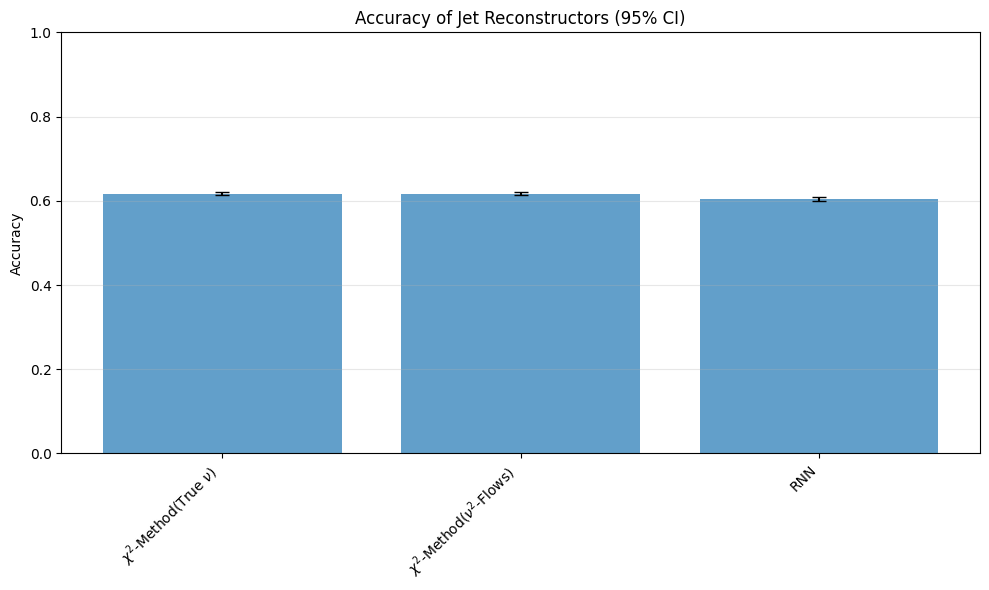

In [6]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing binned top mass resolution for truth_ttbar_mass...


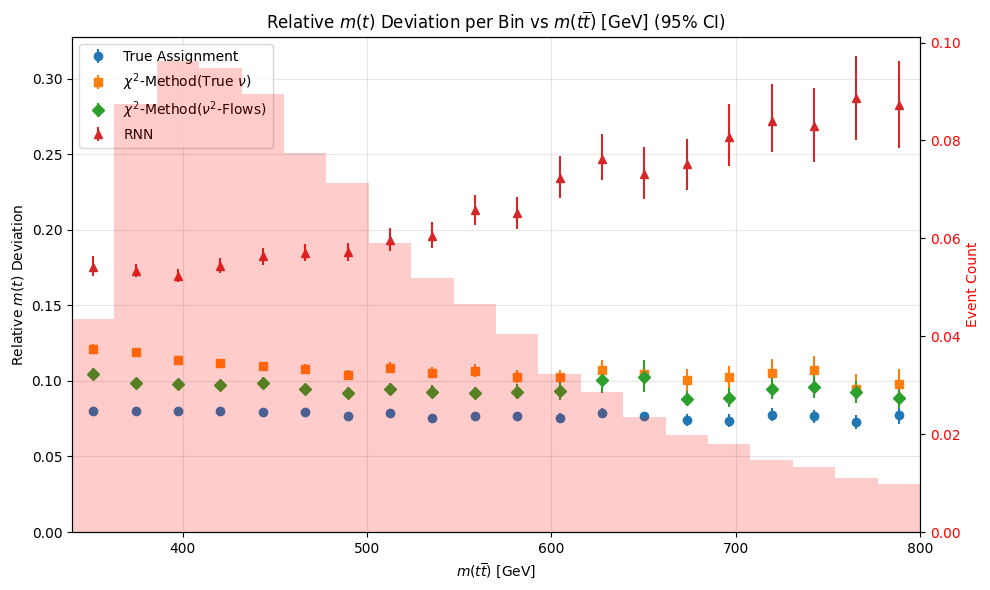

In [7]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")


Computing binned ttbar mass resolution for truth_ttbar_mass...


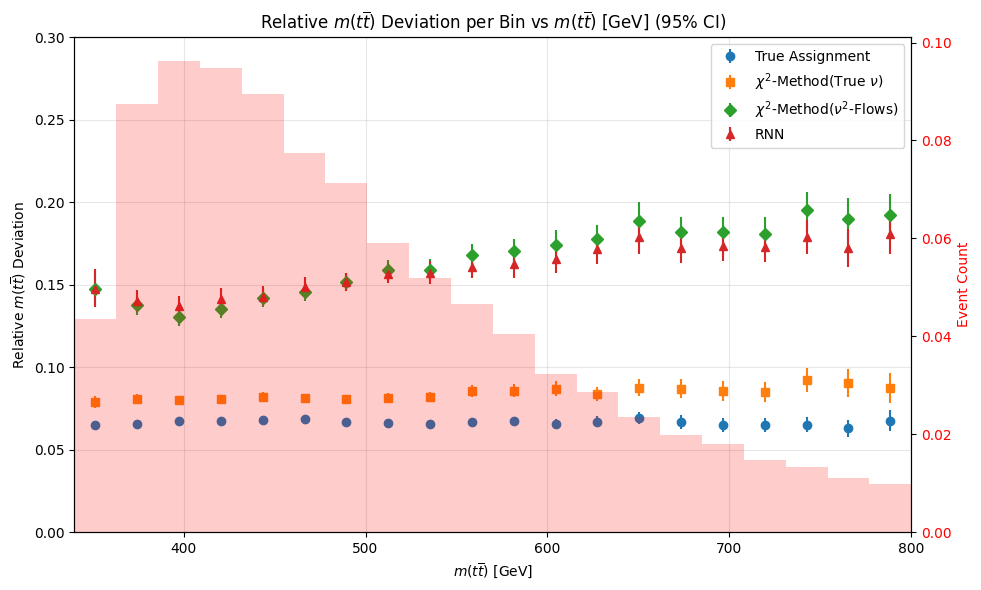

In [8]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
ax.set_ylim(0, 0.3)
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing binned complementarity for truth_ttbar_mass...


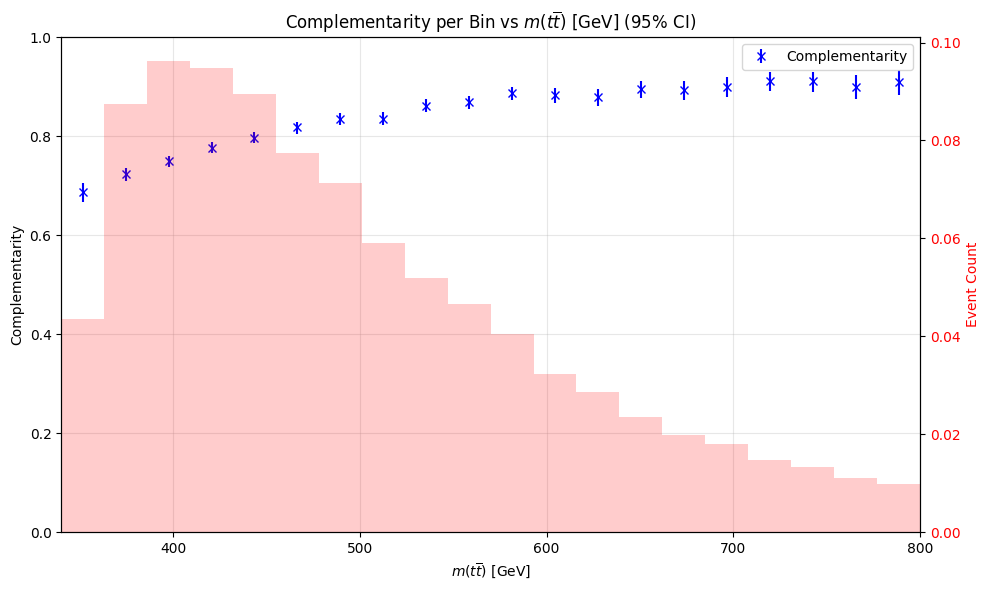

In [9]:
fig, ax = evaluator.plot_binned_complementarity(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "binned_complementarity_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_mass...


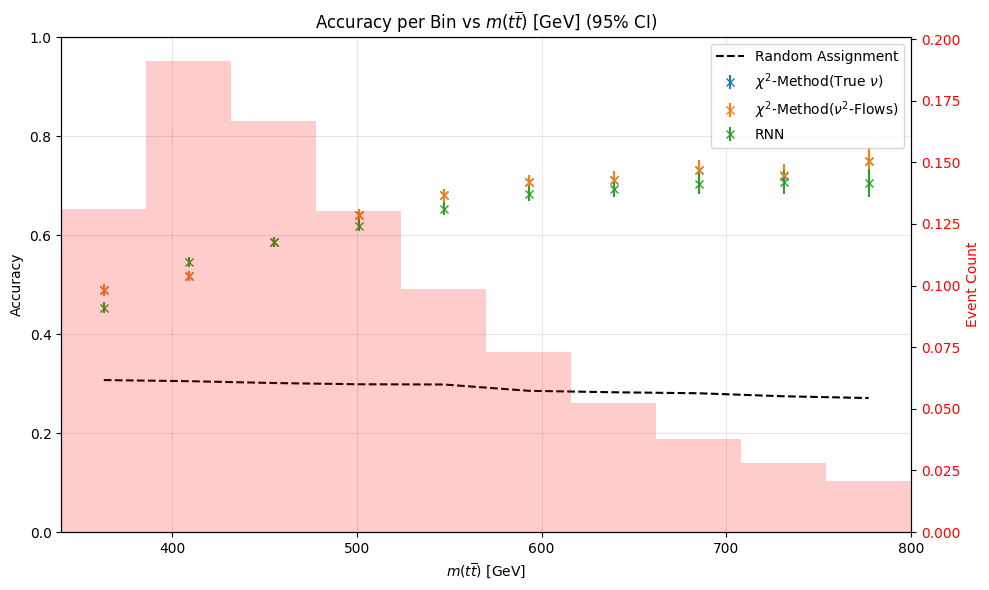

In [10]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


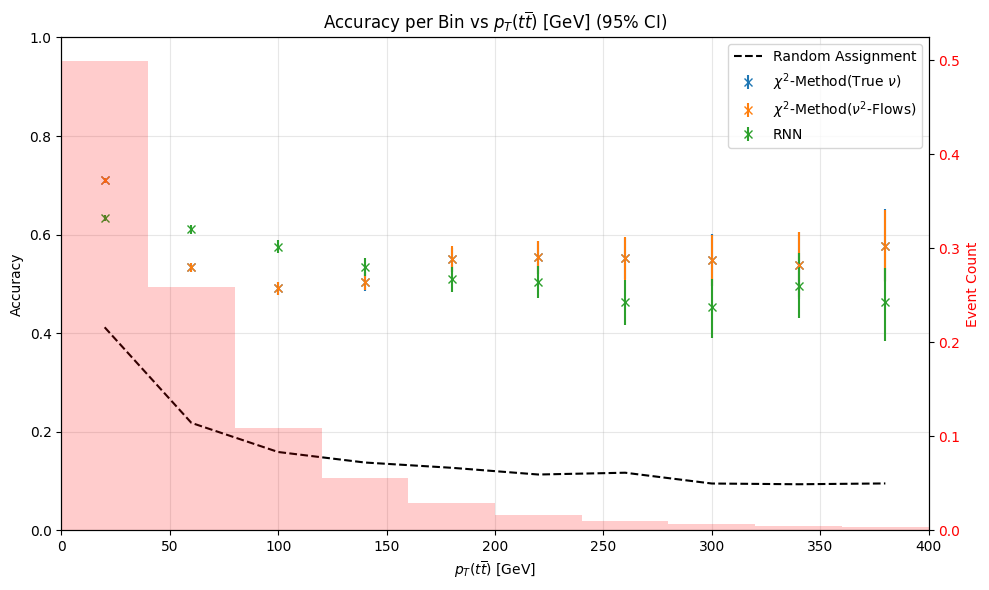

In [11]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


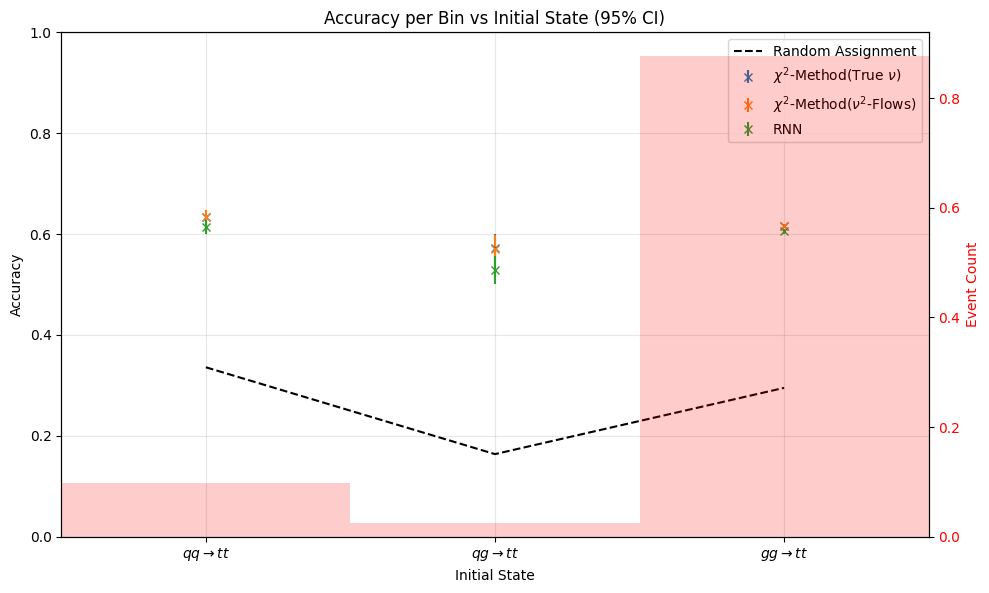

In [12]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")


Computing binned accuracy for N_jets...


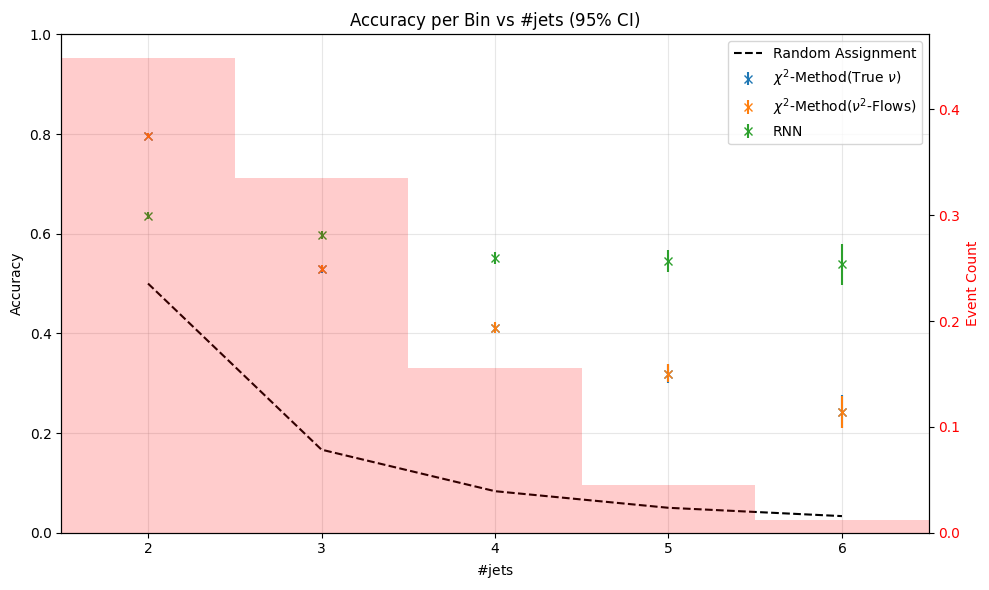

In [13]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_configs["LoadConfig"]["max_jets"] + 1),
    bins=data_configs["LoadConfig"]["max_jets"] - 1,
)
ax.set_xticks([i + 0.5 for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
ax.set_xticklabels([i for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

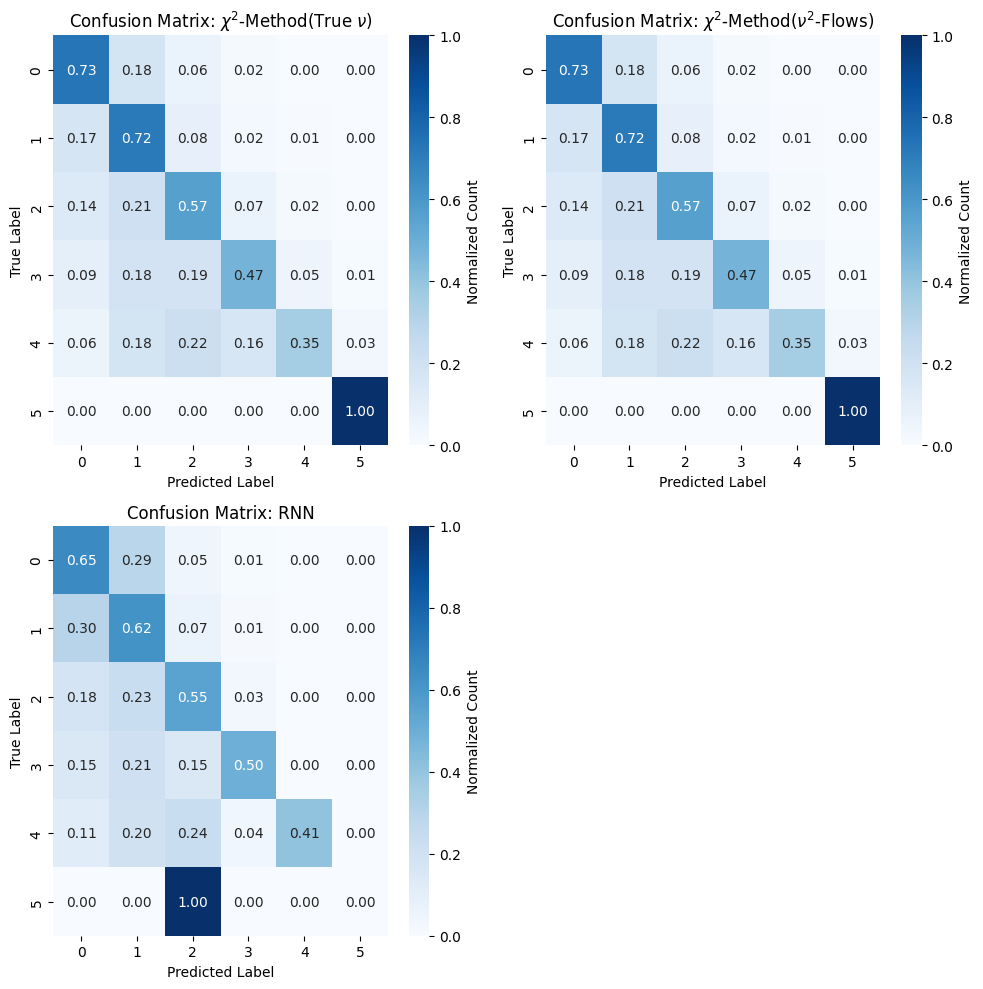

In [14]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

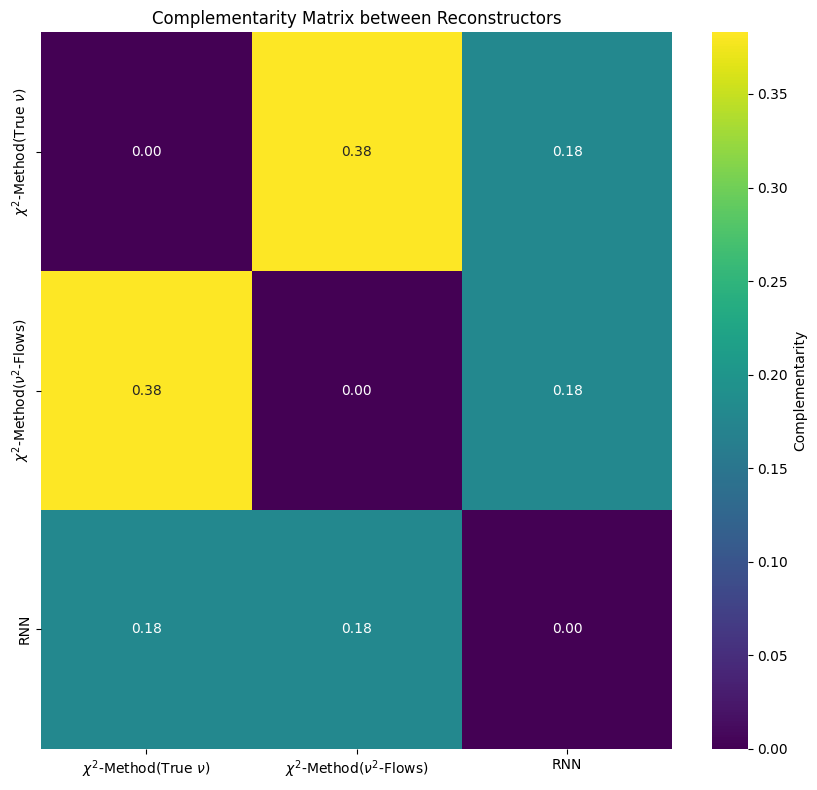

In [15]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(8.5, 8))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")